In [7]:
#rdmc prep 
import pandas as pd

FREQ_POPS = [
    "chrom",
    "start",
    "end",
    "v5--LR--Amatlan_de_Canas",
    "v5--LR--Crucero_Lagunitas",
    "v5--LR--Los_Guajes",
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--random2_Palmar_Chico",
    "v5--LR--San_Lorenzo",
    "v5--Teo--Amatlan_de_Canas",
    "v5--Teo--Crucero_Lagunitas",
    "v5--Teo--El_Rodeo",
    "v5--Teo--Los_Guajes",
    "v5--Teo--random1_Palmar_Chico",
    "v5--Teo--random2_Palmar_Chico",
    "v5--Teo--San_Lorenzo"
]

sweep_df = pd.read_csv("../data/raisd/v5--allpops--shared_outliers.txt", 
            sep = "\t", 
            names = ["chrom", "start", "end", "length", "files"])

sweep_idx = []
for sweep in sweep_df['files']:
    sweep_files = sweep.split(',')
    s_idx = [f"{i+1}" for i,x in enumerate(FREQ_POPS) for s in sweep_files if s.find(x) != -1]
    if len(s_idx) < 2 or len(s_idx) > len(FREQ_POPS)-2:
        sweep_idx.append("NA")
    else:
        sweep_idx.append('-'.join(s_idx))
        
sweep_df['sweep_idx'] = sweep_idx

out_file = [f"sweep_{row['chrom']}_start{str(row['start'])}_end{str(row['end'])}_pops{row['sweep_idx']}.txt" for index, row in sweep_df.iterrows()]
sweep_df['out_file'] = out_file
sweep_df[sweep_df['sweep_idx'] != "NA"]


"""

rule get_sweep:
    input:
        "data/rdmc/freq/allpops--{chrom}--{start}--{end}_freq.txt.gz"
    output:
        "{}"
    params:
        chrom = "{chrom}",
        start = "{start}",
        end = "{end}"
    shell:
    
    awk -v chrom={params.chrom} -v start={params.start} -v end={params.end} '$1==chrom && $2 >= start $$ $3 <= end {{print $0}}' {input} > {output}
    



rule rdmc_cli 
    input:
        gmap = "ogut something something"
        freq_file = ""
    output:
        sweep_{chr1}_start{start}_end{end}_pops{pops}.txt
    params:
        pops = "{pops}",
        start = "{start}",
        end = "{end}"
        
    shell:
    "rdmc_cli --pops {pops} --gmap {gmap} --freqs {freq_file} --start {start} --end {end} -g -s -t"
    
"""

out_file[0]

'sweep_chr1_start17196_end867050_pops4-5-6-7-8-9-10-11-12-13-14-15-16.txt'

In [72]:
import mushi

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import msprime
import tskit
from itertools import tee

from glob import glob

In [85]:
t = np.logspace(np.log10(1), np.log10(200000), 50)
#mu = 3e-8
mu = 1e-7
bps = 10000
c = 1.6e-8

sfs_files = glob("../data/angsd_pi/v5--Teo--random1*.sfs")
sfs_list = []

for sfs_file in sfs_files:
    with open(sfs_file) as f:
        sfs = f.readlines()[0].split()
        sfs_chr = np.array([float(s) for s in sfs])
        sfs_list.append(sfs_chr)

sfs_array = np.asarray(sfs_list)
sfs_all = sfs_array.sum(axis=0)
print(sfs_all)

[4.26842830e+08 8.44963068e+06 4.18664091e+06 2.17393710e+06
 1.27240398e+06 8.21830933e+05 5.75642557e+05 4.29737786e+05
 3.61886515e+05 2.66786633e+05 2.38767150e+05 1.91556458e+05
 1.69395800e+05 1.65859271e+05 1.48677274e+05 1.57244571e+05
 1.47637848e+05 1.48075018e+05 1.51510235e+05 1.62834966e+05
 3.03086313e+05]


inferring η(t)
initial objective -2.783152e+08
iteration 361, objective -2.805e+08, relative change 9.136e-15                                                                                                                                                       
relative change in objective function 9.1e-15 is within tolerance 1e-12 after 361 iterations


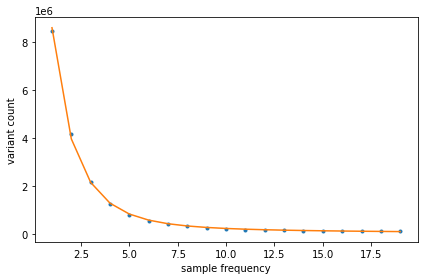

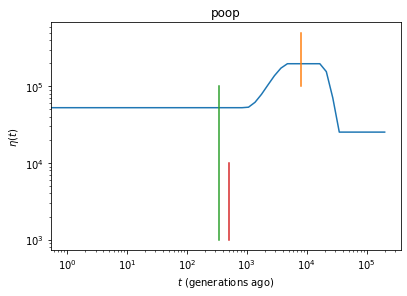

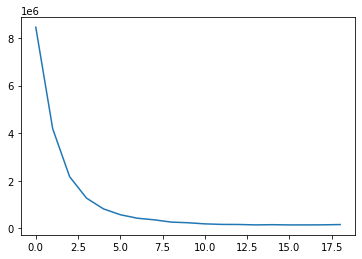

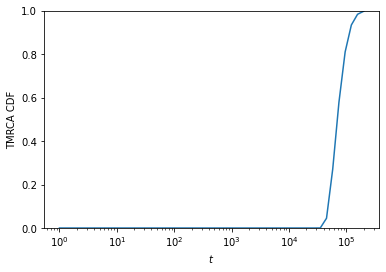

In [86]:
ksfs = mushi.kSFS(np.array(sfs_all[1:-1]))
ksfs.infer_history(t, mu0 = mu*sum(sfs_all), infer_mu=False, folded = False,
                   alpha_tv=1e4, alpha_spline=1e4, alpha_ridge = 1e-1,
                   tol=1e-12, verbose=True, max_iter = 5000)

ksfs.plot_total()
plt.show()
plt.xscale('log')
plt.yscale('log')
ksfs.eta.plot()
plt.title("poop")
plt.plot((8000, 8000), (100000, 500000))
plt.plot((350, 350), (1000, 100000))
plt.plot((500, 500), (1000, 10000))
plt.show()
plt.plot(sfs_all[1:-1])
plt.show()

plt.plot(t, ksfs.tmrca_cdf(ksfs.eta))
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('log')
plt.show()

In [87]:
Nt = ksfs.eta.vals
T = ksfs.eta.change_points

N_0 = Nt[0] / 2
msp_N = Nt[1:] / 2
msp_T = T
nsamp = len(sfs_all)-1

#ms_N = Nt[1:]/N_0
#ms_T = T/(4*N_0)


population_configurations = [msprime.PopulationConfiguration(sample_size = nsamp, initial_size = N_0)]
demography_list = [msprime.PopulationParametersChange(time = t, initial_size = n) for t, n, in zip(msp_T, msp_N)]

ts_mushi = msprime.simulate(
    population_configurations=population_configurations, 
    demographic_events = demography_list, 
    #Ne = N_0, sample_size = nsamp,
    length = bps, 
    recombination_rate = c, 
    mutation_rate = mu, 
    num_replicates = 2000
)

ts_mushi, ts_mushi_copy = tee(ts_mushi)


#pi = [ts.diversity() for ts in ts_mushi]
#td = [ts.Tajimas_D() for ts in ts_mushi]

print(np.nanmean(list(map(lambda a : [a.diversity().item(), a.Tajimas_D().item()], ts_mushi)), axis=0))
#list(map(lambda a : [a.diversity().item(), a.Tajimas_D().item()], ts_mushi))


[ 0.00989869 -0.91296725]


In [88]:
msp_N/N_0

DeviceArray([1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.01499408, 1.17450835,
             1.49253568, 1.98101404, 2.6144743 , 3.28144373, 3.7453654 ,
             3.7453654 , 3.7453654 , 3.7453654 , 3.7453654 , 3.7453654 ,
             2.95619599, 1.34074768, 0.4802945 , 0.4802945 , 0.4802945 ,
             0.4802945 , 0.4802945 , 0.4802945 , 0.4802945 , 0.4802945 ],            dtype=float64)

In [89]:
2231 / 55000

0.040563636363636364

In [90]:
N_0 = Nt[0] / 2
msp_N = (Nt[1:] / 2).astype('int')
msp_T = (T).astype('int')
nsamp = len(sfs_all)-1

N_1 = msp_N[0:-1][::-1]
N_2 = msp_N[1:][::-1]

T_1 = msp_T[0:-1][::-1]
T_2 = msp_T[1:][::-1]

print(', '.join([str(i) for i in N_1]))
print(', '.join([str(i) for i in N_2]))

print(', '.join([str(max(msp_T) - i + 1) for i in T_2]))
print(', '.join([str(max(msp_T) - i) for i in T_1]))


12641, 12641, 12641, 12641, 12641, 12641, 12641, 35289, 77809, 98580, 98580, 98580, 98580, 98580, 98580, 86369, 68814, 52141, 39284, 30913, 26715, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320
12641, 12641, 12641, 12641, 12641, 12641, 12641, 12641, 35289, 77809, 98580, 98580, 98580, 98580, 98580, 98580, 86369, 68814, 52141, 39284, 30913, 26715, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320
1, 44102, 78478, 105274, 126161, 142443, 155135, 165028, 172740, 178751, 183437, 187089, 189936, 192156, 193886, 195234, 196285, 197105, 197744, 198241, 198630, 198932, 199168, 199352, 199495, 199607, 199694, 199762, 199814, 199856, 199888, 199913, 199932, 199948, 199960, 199969, 199976, 199982, 199986, 199989, 199

In [91]:
print(N_0)
((462.9318338034885  + 694.3977507052326)/2)/(4*3e-8*55000)

26320.720737689062


87676.48367490312

In [97]:
print(2 * 87676 * 0.001)
print(2 * N_0 * 0.001)

175.352
52.64144147537812


# RDMC PREP